## Configurations and libraries

**Important note**

Generate the `FER2013+` dataset before running the application


In [78]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision  
from  torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from FERPlusDataset import FERPlusDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import random
import os
from datetime import datetime

device = torch.device("mps" if torch.mps.is_available() else "cpu")

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure the checkpoint directory exists

# device = "cpu"
# Paths to dataset directories
train_dir = "./data/FER2013Train"
val_dir = "./data/FER2013Valid"
test_dir = "./data/FER2013Test"

# Paths to labels
train_csv = "./data/FER2013Train/label.csv"
val_csv = "./data/FER2013Valid/label.csv"
test_csv = "./data/FER2013Test/label.csv"

In [79]:
def check_data_availability(image_dir, label_csv):
    if not os.path.exists(image_dir):
        print(f"Error: Directory {image_dir} does not exist.")
        return False

    png_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    if len(png_files) == 0:
        print(f"Error: No .png files found in directory {image_dir}.")
        return False

    # Check if label CSV exists
    if not os.path.exists(label_csv):
        print(f"Error: Label file {label_csv} does not exist.")
        return False

    print(f"Data check passed for {image_dir} and {label_csv}.")
    return True

# Check all directories
if (
    check_data_availability(train_dir, train_csv) and
    check_data_availability(val_dir, val_csv) and
    check_data_availability(test_dir, test_csv)
):
    print("All data is available and ready for training!")
else:
    print("Data check failed. Please fix the errors and try again.")


Data check passed for ./data/FER2013Train and ./data/FER2013Train/label.csv.
Data check passed for ./data/FER2013Valid and ./data/FER2013Valid/label.csv.
Data check passed for ./data/FER2013Test and ./data/FER2013Test/label.csv.
All data is available and ready for training!


## Data Preprocessing

`Challenge:`

What is the proper way to augment dataset?

There are 2 ways to apply augmentation:
* On the fly (when loading custom `Dataset`, pass original image and augmented image)
* Create a separate augmented dataset and combine with original 

`Solution:`

We chose to create a separate dataset and combine it with original one.




In [80]:
# Apply transformations and augmentation
main_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor() ,  
    transforms.Normalize((0.5,), (0.5,), (0.5,),)  
])

train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # Reduce rotation degrees
    transforms.ColorJitter(brightness=0.05, contrast=0.05),  # Subtle jitter
    transforms.RandomResizedCrop(size=(40, 40), scale=(0.9, 1.0)),  # Reduce crop range
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_first_dataset = FERPlusDataset(image_dir=train_dir, aug_transform=train_augmentation, transform=main_transform, label_csv=train_csv, mode="majority")

test_dataset = FERPlusDataset(image_dir=test_dir, aug_transform=None, transform=main_transform, label_csv=test_csv, mode="majority")
validation_dataset = FERPlusDataset(image_dir=val_dir, aug_transform=None, transform=main_transform, label_csv=val_csv, mode="majority")

# Create data loaders
batch_size = 64  
    
train_loader = DataLoader(train_first_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [81]:
# Debugging a sample
for img, label in train_loader:
    print(f"Image type: {type(img)}, Image shape: {img.shape}")
    break


Image type: <class 'torch.Tensor'>, Image shape: torch.Size([64, 3, 48, 48])


## CNN Architecture
4 blocks:
* Convolutional layer
* Normalization layer
* `ReLU` activation function
* Convolutional layer
* Normalization layer
* `ReLU` activation function
* `Max Pooling` layer

last 5-th block:  
Same as previous. Without Pooling layer

1 dense layer

**Challenge**: Model takes more than `10 minutes` to train   
**Suggested solution**: Decrease the amount of out_channels in convolutional layers and add Normalization.  
**Result**: Model takes `15% less time` compared to previous runs(ran on `cpu`)


In [82]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.6, num_emotions=2):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.num_emotions = num_emotions
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Block 4
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Block 5
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        dummy_input = torch.zeros(1, 3, 48, 48)  # Assuming input image size (3, 48, 48)
        self.flatten_size = self._get_flatten_size(dummy_input)

        self.dense_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=256, out_features=128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=128, out_features=num_emotions)  # Output layer for num_emotions classes
        )
        
    def _get_flatten_size(self, x):
        """Calculate the flatten size dynamically by passing a dummy input."""
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.dense_layer(x)
        return x


## Regularization: Early stopping

In [83]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience # Number of epochs to wait before stopping
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


## Train the model

In [84]:
def early_stopping_triggered(early_stopping, val_loss):
    """Check and handle early stopping condition."""
    early_stopping(val_loss)
    return early_stopping.early_stop

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """Train the model for one epoch and compute metrics."""
    model.train()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Store predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    train_accuracy = accuracy_score(all_labels, all_predictions)
    train_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    train_recall = recall_score(all_labels, all_predictions, average='weighted')
    train_f1 = f1_score(all_labels, all_predictions, average='weighted')

    return running_loss / len(train_loader), train_accuracy, train_precision, train_recall, train_f1


def validate_model(model, val_loader, criterion, device):
    """Evaluate the model on the validation set and compute metrics."""
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

            # Store predictions and labels for metrics
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    val_accuracy = accuracy_score(all_labels, all_predictions)
    val_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    val_recall = recall_score(all_labels, all_predictions, average='weighted')
    val_f1 = f1_score(all_labels, all_predictions, average='weighted')

    return val_loss / len(val_loader), val_accuracy, val_precision, val_recall, val_f1


def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, early_stopping):
    """Train the model with validation, metrics, and early stopping."""
    
    writer = SummaryWriter(f"runs/model{datetime.now()}")
    training_dir = f"{checkpoint_dir}/training/"
    os.makedirs(training_dir, exist_ok=True)  # Ensure the checkpoint directory exists

    
    for epoch in range(num_epochs):
        # Training
        train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # Validation
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate_model(
            model, val_loader, criterion, device
        )

        
        if epoch == num_epochs - 1:
            print("================================")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 score: {train_f1:.4f}")
            print("================================")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f}")
            print(f"Val Precision {val_precision:.4f}")
            print(f"Val Recall: {val_recall:.4f}")
            print(f"Val F1 score: {val_f1:.4f}")
        else: 
            print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        writer.add_scalar("Loss/Train", train_loss, epoch + 1)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch + 1)
        writer.add_scalar("Precision/Train", train_precision, epoch + 1)

        # Save model checkpoint
        checkpoint_path = os.path.join(f"{checkpoint_dir}/training/", f"epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        
        # Early Stopping
        if early_stopping_triggered(early_stopping, val_loss):
            print("Early stopping triggered!")
            print("================================")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 score: {train_f1:.4f}")
            print("================================")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f}")
            print(f"Val Precision {val_precision:.4f}")
            print(f"Val Recall: {val_recall:.4f}")
            print(f"Val F1 score: {val_f1:.4f}")
            break
        
        
        


## Run training process

In [85]:
early_stopping = EarlyStopping(patience=8)
model = CNN(dropout_rate=0.4, num_emotions=8).to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-7)

# Train the model
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20,
    early_stopping=early_stopping,
)

Epoch 1/20 Train Loss: 1.5351, Val Loss: 1.4489
Epoch 2/20 Train Loss: 1.2891, Val Loss: 1.2647
Epoch 3/20 Train Loss: 1.0584, Val Loss: 1.1871
Epoch 4/20 Train Loss: 0.9699, Val Loss: 0.9868
Epoch 5/20 Train Loss: 0.8954, Val Loss: 0.8780
Epoch 6/20 Train Loss: 0.8427, Val Loss: 0.7594
Epoch 7/20 Train Loss: 0.7939, Val Loss: 0.7138
Epoch 8/20 Train Loss: 0.7545, Val Loss: 0.6986
Epoch 9/20 Train Loss: 0.7273, Val Loss: 0.7002
Epoch 10/20 Train Loss: 0.6936, Val Loss: 0.6508
Epoch 11/20 Train Loss: 0.6799, Val Loss: 0.7016
Epoch 12/20 Train Loss: 0.6485, Val Loss: 0.6386
Epoch 13/20 Train Loss: 0.6256, Val Loss: 0.6643
Epoch 14/20 Train Loss: 0.6059, Val Loss: 0.6452
Epoch 15/20 Train Loss: 0.5920, Val Loss: 0.7011
Epoch 16/20 Train Loss: 0.5721, Val Loss: 0.5274
Epoch 17/20 Train Loss: 0.5497, Val Loss: 0.6764
Epoch 18/20 Train Loss: 0.5236, Val Loss: 0.5786
Epoch 19/20 Train Loss: 0.5168, Val Loss: 0.5621
Train Loss: 0.4883
Train Accuracy: 0.8367
Train Precision 0.8336
Train Recall:

In [86]:
from torchsummary import summary
summary(model.to("cpu"), input_size=(3, 48, 48), device="cpu")

# Move the model back to the MPS device for training
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]           9,248
       BatchNorm2d-5           [-1, 32, 48, 48]              64
              ReLU-6           [-1, 32, 48, 48]               0
         MaxPool2d-7           [-1, 32, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          18,496
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11           [-1, 64, 24, 24]          36,928
      BatchNorm2d-12           [-1, 64, 24, 24]             128
             ReLU-13           [-1, 64, 24, 24]               0
        MaxPool2d-14           [-1, 64,

## Evaluate the model

/Users/mihajlokruc/Developer/ACS_DATA_AI_5/dl_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.8345
Test Precision 0.8287
Test Recall: 0.8345
Test F1 score: 0.8285


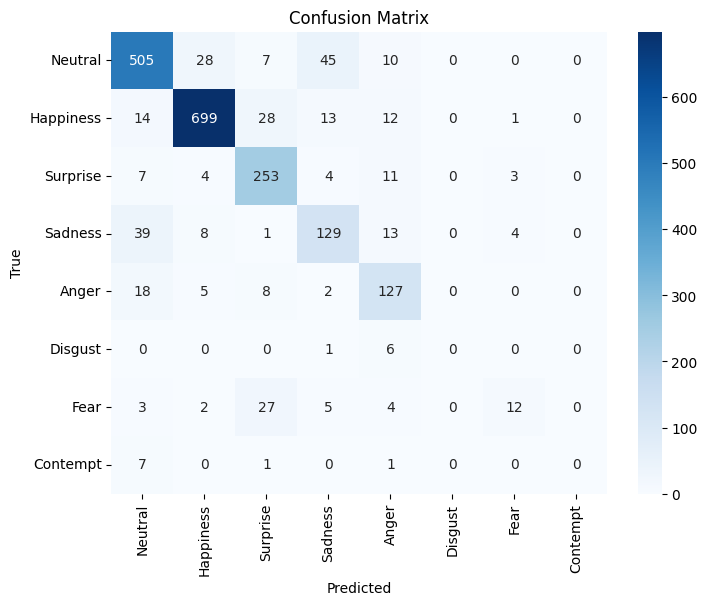

In [87]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 score: {f1:.4f}")
    return metrics

metrics = evaluate_model(model, test_loader, device)

emotion_labels = [
    "Neutral", "Happiness", "Surprise", "Sadness", 
    "Anger", "Disgust", "Fear", "Contempt"
]

all_labels = []  # True labels
all_predictions = []  # Model predictions

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Future work recommendation and Interpretation of the results

**Overfitting**: Large gap between training and validation performance.  
**Underfitting**: Both training and validation performances are poor.  
**Good Model**: Training and validation performances are aligned and good.  


### What to do next?

`Addressing Class Imbalance:`  

Use weighted loss functions (e.g., weighted cross-entropy) to penalize misclassification of minority classes more heavily.

`Augmentation Pipeline Enhancements:`  

Add more complex data augmentation techniques such as color jitter, Gaussian blur, or random noise injection to make the model more robust to real-world variability.

# Save the model

In [88]:
os.makedirs("models/", exist_ok=True) 

if metrics['accuracy'] > 80:
    torch.save(model, "models/model_>80.pth")

## Hyperparameter tuning: Random Search 

`Observed problem:`  

As seen in hyperparameter tuning and just by running the model manually, our team found out  
that model accuracy becomes `worse` if we utilize the `L2 regularization` for Adam Optimizer

`Proposed Solution:` 

Avoid using L2 regularization in basic run

In [91]:
def random_search_with_logging(train_loader, val_loader, num_trials, device, ):
    param_grid = {
        'learning_rate': [1e-4, 5e-4, 1e-3, 5e-3],
        'dropout_rate': [0.3, 0.4, 0.5, 0.6],
        'weight_decay': [1e-5, 1e-4, 1e-3],
        'batch_size': [16, 32, 64, 128]
    }

    random_search_dir = f"{checkpoint_dir}/tuning/"
    os.makedirs(random_search_dir, exist_ok=True) 

    best_val_loss = float('inf')
    best_params = None

    for trial in range(num_trials):

        lr = random.choice(param_grid['learning_rate'])
        dropout_rate = random.choice(param_grid['dropout_rate'])
        weight_decay = random.choice(param_grid['weight_decay'])
        batch_size = random.choice(param_grid['batch_size'])

        print(f"\nTrial {trial + 1}/{num_trials}:")
        print(f"Learning Rate: {lr}, Dropout Rate: {dropout_rate}, Weight Decay: {weight_decay}, Batch Size: {batch_size}")


        ## Apply random hyperparameter values
        train_loader = DataLoader(train_first_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        model = CNN(dropout_rate=dropout_rate, num_emotions=8).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # TensorBoard writer for this trial
        writer = SummaryWriter(log_dir=f"runs/trial_{trial + 1}")

        # Train the model
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)

            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_targets).item()

                    _, predicted = torch.max(val_outputs, 1)
                    correct += (predicted == val_targets).sum().item()
                    total += val_targets.size(0)

            val_loss /= len(val_loader)
            val_accuracy = correct / total

            # Log to TensorBoard
            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Loss/Validation", val_loss, epoch)
            writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Save checkpoint for the current trial
            torch.save(model.state_dict(), f"{random_search_dir}trial_{trial + 1}_epoch_{epoch + 1}.pth")

        # Update best parameters if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = {
                'learning_rate': lr,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'batch_size': batch_size
            }
            print(f"New best parameters found: {best_params}, Val Loss: {best_val_loss:.4f}")

        writer.close()  

    print("\nRandom Search Complete!")
    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    return best_params, best_val_loss


def run_with_best_params(best_params, train_loader, val_loader, test_loader, num_epochs, device):
    print("\nTraining with Best Parameters:")
    print(f"Learning Rate: {best_params['learning_rate']}, Dropout Rate: {best_params['dropout_rate']}, "
          f"Weight Decay: {best_params['weight_decay']}, Batch Size: {best_params['batch_size']}")

    # Adjust DataLoaders with the best batch size
    train_loader = DataLoader(train_first_dataset,
                               batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=best_params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    # Initialize model, optimizer, and criterion
    model = CNN(dropout_rate=best_params['dropout_rate'], num_emotions=8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    # Early stopping setup
    early_stopping = EarlyStopping(patience=5)

    # Train the model
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=num_epochs,
        early_stopping=early_stopping
    )

    # Evaluate the model on the test set
    test_metrics = evaluate_model(model, test_loader, device)

    # Plot confusion matrix
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return model, test_metrics


## Run with best parameters

In [92]:
best_params, best_val_loss = random_search_with_logging(train_loader, val_loader, num_trials=5, device=device)

model, test_metrics = run_with_best_params(
    best_params=best_params,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=20,
    device=device
)


Trial 1/5:
Learning Rate: 0.0005, Dropout Rate: 0.5, Weight Decay: 0.001, Batch Size: 64
Epoch 1/10, Train Loss: 1.3683, Val Loss: 1.0789, Val Accuracy: 0.6642
Epoch 2/10, Train Loss: 1.0275, Val Loss: 1.0031, Val Accuracy: 0.6446
Epoch 3/10, Train Loss: 0.9066, Val Loss: 0.7964, Val Accuracy: 0.7377
Epoch 4/10, Train Loss: 0.8436, Val Loss: 0.7473, Val Accuracy: 0.7499
Epoch 5/10, Train Loss: 0.8151, Val Loss: 1.1959, Val Accuracy: 0.6250
Epoch 6/10, Train Loss: 0.7711, Val Loss: 0.8397, Val Accuracy: 0.7148
Epoch 7/10, Train Loss: 0.7519, Val Loss: 0.6580, Val Accuracy: 0.7784
Epoch 8/10, Train Loss: 0.7295, Val Loss: 0.7737, Val Accuracy: 0.7584
Epoch 9/10, Train Loss: 0.7135, Val Loss: 0.6821, Val Accuracy: 0.7750
Epoch 10/10, Train Loss: 0.6979, Val Loss: 0.8133, Val Accuracy: 0.7008
New best parameters found: {'learning_rate': 0.0005, 'dropout_rate': 0.5, 'weight_decay': 0.001, 'batch_size': 64}, Val Loss: 0.8133

Trial 2/5:
Learning Rate: 0.0001, Dropout Rate: 0.6, Weight Decay

NameError: name 'train_second_dataset' is not defined